# Infosys BRSR Principle 6 — Faithfulness Mapper

This notebook contains a full reproducible pipeline. It is provided as a sequence of **executable code blocks** (as fenced code) that you can copy into cells and run. This approach avoids environment-dependent issues in this shared environment.

Sections:
- Installation
- Configuration
- PDF extraction
- Cleaning & chunking
- Embeddings (local/OpenAI)
- Vector store (FAISS)
- Retrieval & RAG
- Concept mapping & drift scoring
- Visualizations (Sankey & Dashboard)
- Pipeline skeleton


## 1) Installation

run the following in a notebook cell if you need to install dependencies:



In [ ]:
# Python packages (choose based on your preference)
pip install PyPDF2 sentence-transformers faiss-cpu plotly pandas matplotlib nbformat
# Optional (OpenAI)
pip install openai tiktoken chromadb unstructured

## 2) Configuration

Set paths and environment variables. Example (put in a code cell):


If you use OpenAI, export your API key in the environment before launching Jupyter:
```bash
export OPENAI_API_KEY='sk-...'
```



In [15]:
import os
SEBI_BRSR_PDF = 'brsr_sebi_2021.pdf'
INFOSYS_BRSR_PDF = 'brsr_infosys_2023.pdf'
OUTPUT_DIR = './infosys_brsr_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY', '')  # if using OpenAI

## 3) PDF Extraction (code snippet)

Use `PyPDF2` for a simple extraction.

```python


# Example:
# sebi_text = extract_text_pypdf(SEBI_BRSR_PDF)
# infosys_text = extract_text_pypdf(INFOSYS_BRSR_PDF)
```



In [16]:
from PyPDF2 import PdfReader

def extract_text_pypdf(path, max_pages=None):
    reader = PdfReader(path)
    texts = []
    num_pages = len(reader.pages)
    if max_pages:
        num_pages = min(num_pages, max_pages)
    for i in range(num_pages):
        page = reader.pages[i]
        texts.append(page.extract_text() or '')
    return '\n'.join(texts)

## 4) Cleaning & Chunking

```python


# Example:
# cleaned = clean_text(infosys_text)
# chunks = chunk_text(cleaned, chunk_size=300, overlap=50)
```



In [17]:
import re

def clean_text(text):
    text = text.replace('\x0c', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def chunk_text(text, chunk_size=400, overlap=50):
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunk = ' '.join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap
    return chunks

## 5) Embeddings (Local and OpenAI examples)

In [18]:
### Local (sentence-transformers)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast
def embed_texts_local(texts):
    return model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

In [5]:
# OpenAI (if you prefer)
import openai
openai.api_key = OPENAI_API_KEY

def embed_texts_openai(texts, model='text-embedding-3-large'):
    # batch for large input
    resp = openai.Embedding.create(model=model, input=texts)
    vectors = [r['embedding'] for r in resp['data']]
    return vectors

## 6) Vector Store — FAISS example

In [19]:
import numpy as np
import faiss

def build_faiss_index(vectors_np):
    dim = vectors_np.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(vectors_np.astype('float32'))
    return index

# Query example:
# D, I = index.search(query_vector.astype('float32'), k)

## 7) Retrieval & RAG skeleton

In [20]:
def retrieve_top_k(query, chunks, index, embed_fn, k=5):
    q_emb = embed_fn([query])
    import numpy as np
    q_emb = np.array(q_emb).astype('float32')
    D, I = index.search(q_emb, k)
    results = [chunks[i] for i in I[0]]
    return results

# After retrieval, build a prompt that includes only retrieved evidence and ask the LLM to answer using it.
# Example prompt outline:
# "You are given the following evidence chunks (labelled). Using ONLY this evidence, answer whether the company's disclosure matches the BRSR requirement X. Quote evidence and give a drift score 0-3. Do not invent facts.":

## 8) Concept Mapping & Drift Scoring

Define Principle 6 concepts and a scoring rule. You may start with a naive keyword overlap and then refine.

In [21]:
BRSR_PRINCIPLE_6_CONCEPTS = [
    'Energy consumption','Energy efficiency','Water withdrawal','Water recycling',
    'GHG emissions','Scope 1 emissions','Scope 2 emissions','Scope 3 emissions',
    'Waste management','Hazardous waste','Biodiversity','Supply chain environmental criteria'
]

def naive_drift_score(concept, evidence_text):
    concept_tokens = set(concept.lower().split())
    evidence_tokens = set(evidence_text.lower().split())
    overlap = len(concept_tokens & evidence_tokens)
    import math
    score = 3 - min(3, math.floor(overlap / max(1, len(concept_tokens))))
    return score

# This function is intentionally simple — use LLM judgment or heuristics for better accuracy.

## 9) Visualizations — Sankey & Drift Dashboard

Example code to produce a Sankey diagram (Plotly) and a simple dashboard (pandas + matplotlib/plotly).

For the drift dashboard, color-code drift 0 (green) to 3 (red) using matplotlib or plotly bar charts.


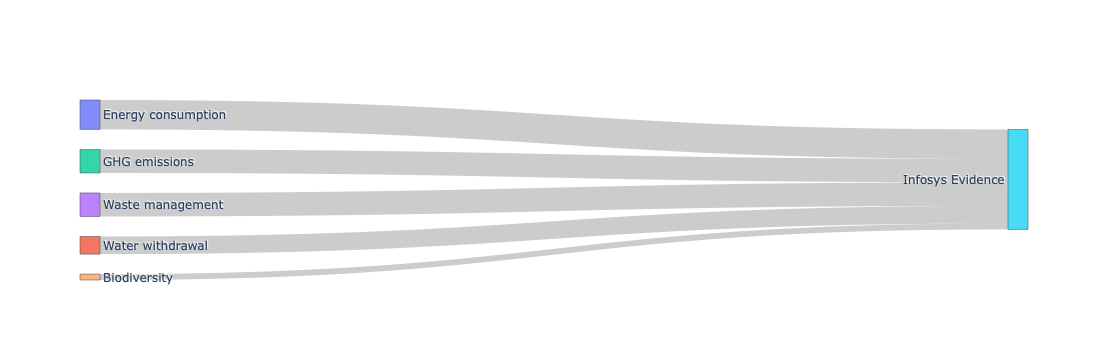

In [22]:
import pandas as pd
import plotly.graph_objects as go

# Example dataframe (replace with real results)
df = pd.DataFrame([
    {'concept':'Energy consumption','evidence_count':5,'drift':0},
    {'concept':'Water withdrawal','evidence_count':3,'drift':1},
    {'concept':'GHG emissions','evidence_count':4,'drift':1},
    {'concept':'Waste management','evidence_count':4,'drift':0},
    {'concept':'Biodiversity','evidence_count':1,'drift':2},
])

labels = df['concept'].tolist() + ['Infosys Evidence']
source = list(range(len(df)))
target = [len(df)] * len(df)
value = df['evidence_count'].tolist()

fig = go.Figure(data=[go.Sankey(node=dict(label=labels), link=dict(source=source, target=target, value=value))])
fig.show()
# fig.write_html('sankey.html')

## 10) Pipeline Skeleton — Run end-to-end

Outline (put as code and run when all dependencies are ready):
After running, generate visualizations and copy top evidence quotes into the Word report.


In [23]:
# 1. Extract text from SEBI & Infosys PDFs
sebi_text = extract_text_pypdf(SEBI_BRSR_PDF)
infosys_text = extract_text_pypdf(INFOSYS_BRSR_PDF)

# 2. Clean & chunk
infosys_chunks = chunk_text(clean_text(infosys_text))

# 3. Embeddings (local recommended)
infosys_embs = embed_texts_local(infosys_chunks)  # or embed_texts_openai

# 4. Build FAISS index
import numpy as np
index = build_faiss_index(np.array(infosys_embs))

# 5. For each concept, retrieve top-k and compute score
results = []
for concept in BRSR_PRINCIPLE_6_CONCEPTS:
    top = retrieve_top_k(concept, infosys_chunks, index, embed_texts_local, k=5)
    evidence = ' '.join(top)
    score = naive_drift_score(concept, evidence)
    results.append({'concept':concept,'score':score,'evidence':' || '.join([t[:300] for t in top])})

import pandas as pd
pd.DataFrame(results).to_csv(f'{OUTPUT_DIR}/faithfulness_results.csv', index=False)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
df = pd.DataFrame(results)

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
# optional: make renderer work well in Jupyter
pio.renderers.default = "iframe_connected"  # or "notebook_connected" or "colab"

# load results (or use df variable you already have)
# df = pd.read_csv(f'{OUTPUT_DIR}/faithfulness_results.csv')  # if saved
# assuming df exists already from your pipeline

# 1) Create numeric evidence_count for Sankey values
# If you stored top-k chunks per concept (as evidence string separated by ' || '), count them:
def count_chunks(evidence_str):
    if not isinstance(evidence_str, str) or evidence_str.strip() == "":
        return 0
    return len(evidence_str.split(' || '))

df['evidence_count'] = df['evidence'].apply(count_chunks)

# If every concept always has some evidence and you prefer strength by length:
# df['evidence_strength'] = df['evidence'].apply(lambda s: len(s))

# 2) Sankey labels: concepts + single sink node "Infosys Evidence"
labels = df['concept'].tolist() + ['Infosys Evidence']

# 3) sources = index of each concept (0..n-1), target = index of sink node (n)
source = list(range(len(df)))
target = [len(df)] * len(df)   # each concept links to the single sink

# 4) values must be numeric: use evidence_count (or evidence_strength)
value = df['evidence_count'].astype(int).tolist()

# sanity check: ensure lengths match
assert len(source) == len(target) == len(value) == len(df)

# 5) Build and show Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=20, thickness=20),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="BRSR Principle 6 → Infosys Evidence (Sankey)", font_size=12)

# save and show
fig.write_html(f"{OUTPUT_DIR}/sankey_concept_to_evidence.html")
fig.show()
print("Sankey saved to:", f"{OUTPUT_DIR}/sankey_concept_to_evidence.html")


Sankey saved to: ./infosys_brsr_outputs/sankey_concept_to_evidence.html


---

**Notes & Recommendations**

- The notebook provides a reproducible framework. Human review is essential for final drift scoring and non-hallucination checks.
- For best results, create a prompt template that forces the LLM to quote retrieved chunks with page numbers.
- Keep all extracted chunk IDs and page references to support the citations required by the assignment.

